In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2
from histo_utilities import create_TH1D, make_ratio_plot, create_TH2D, std_color_list, rootTH1_to_np, SetMaxToMaxHist

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 7*' ' + 'Internal'

In [3]:
candDir='ntuples_B2DstMu_220225'
skimmedTag=''
MCsample = {
######## Signals
'tau': DSetLoader('Bd_TauNuDst', candDir=candDir, skimmedTag=skimmedTag),
'mu': DSetLoader('Bd_MuNuDst', candDir=candDir, skimmedTag=skimmedTag),
######## D** background
'Bu_MuDstPi': DSetLoader('Bu_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_MuDstPi': DSetLoader('Bd_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi_v3', candDir=candDir, skimmedTag=skimmedTag),
'Bu_MuDstPiPi': DSetLoader('Bu_MuNuDstPiPi_v3', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPi': DSetLoader('Bu_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPi': DSetLoader('Bd_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPiPi': DSetLoader('Bd_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPiPi': DSetLoader('Bu_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bs_MuDstK': DSetLoader('Bs_MuNuDstK', candDir=candDir, skimmedTag=skimmedTag),
'Bs_TauDstK': DSetLoader('Bs_TauNuDstK', candDir=candDir, skimmedTag=skimmedTag),
######## D*Hc background
'Bd_DstDu': DSetLoader('Bd_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDu': DSetLoader('Bu_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDd': DSetLoader('Bd_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDd': DSetLoader('Bu_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDs': DSetLoader('Bd_DstDs', candDir=candDir, skimmedTag=skimmedTag),
'Bs_DstDs': DSetLoader('Bs_DstDs', candDir=candDir, skimmedTag=skimmedTag),
######## Others
'Bd_DDs1': DSetLoader('Bd_DDs1', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DDs1': DSetLoader('Bu_DDs1', candDir=candDir, skimmedTag=skimmedTag),
'B_DstDXX': DSetLoader('B_DstDXX', candDir=candDir, skimmedTag=skimmedTag),
}

CAND efficiency file missing for Bd_DDs1.
CAND efficiency file missing for Bu_DDs1.
CAND efficiency file missing for B_DstDXX.


In [4]:
category = 'Low'
weights_version = 'v16_base'

In [5]:
df = {}
for n, MCs in MCsample.iteritems():
    df[n] = pd.DataFrame(rtnp.root2array(MCs.skimmed_dir + '/'+category.capitalize()+'_trkCtrl_bare.root'))
    wFile = MCs.skimmed_dir + '/weights/'+category.capitalize()+'trkCtrl_bare_'+weights_version+'_'+category.lower()+'_CLN_blinded.root'
    if os.path.isfile(wFile):
        w = pd.DataFrame(rtnp.root2array(wFile))
        df[n]['w'] = w['central']

Bd_MuDstPiPi
tau
Bu_DDs1
Bs_DstDs
Bd_TauDstPi
Bu_MuDstPiPi
Bs_MuDstK
Bd_MuDstPi
Bu_TauDstPi
Bd_DstDd
Bu_DstDu
mu
Bd_DstDs
Bd_TauDstPiPi
Bd_DDs1
Bd_DstDu
Bu_TauDstPiPi
Bs_TauDstK
Bu_MuDstPi
B_DstDXX
Bu_DstDd


In [6]:
dataLoc = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD/skimmed/'
df['SSDstMu'] = pd.DataFrame(rtnp.root2array(dataLoc+'B2DstMu_SS_220301_'+category.capitalize()+'_trkCtrl_corr.root'))
df['data'] = pd.DataFrame(rtnp.root2array(dataLoc+'B2DstMu_220220_'+category.capitalize()+'_trkCtrl_corr.root'))

# Draw plots

In [7]:
def exploreDifference(var, binning, nRows=2):
    h_dic = {}
    h_tot = None
    for n, d in df.iteritems():
    #     print n
        sel = np.logical_and(d['tkCharge_0']+d['tkCharge_1'] == 0, d['N_goodAddTks'] == 2)
        sel = np.logical_and(d['massVisTks'] < 5.55, sel)
    #     print 'Sel eff: {:.1f}%'.format(100*np.sum(sel)/float(d.shape[0]))

        h = create_TH1D(d[var][sel], name='h_'+var+'_'+n, binning=binning, 
                        weights=d['w'][sel] if 'w' in d.columns else None)
        h_dic[n] = h
        if not n in ['data', 'Bd_DDs1', 'Bu_DDs1', 'B_DstDXX']:
            if h_tot is None:
                h_tot = h.Clone('h_'+var+'_tot')
            else:
                h_tot.Add(h)

    h_diff = h_dic['data'].Clone('h_'+var+'_diff')
    h_diff.Add(h_tot, -1)
    for i in range(1, h_diff.GetNbinsX()+1):
        if h_diff.GetBinContent(i) < 0:
            h_diff.SetBinContent(i, 0)

    h_dic['data'].Sumw2()
    h_dic['data'].SetXTitle(var)
    h_tot.SetLineColor(std_color_list[0])
    h_diff.SetLineColor(std_color_list[1])
    c = drawOnCMSCanvas(CMS_lumi, [h_dic['data'], h_tot, h_diff], 'same', size=[400, 300],
                        makeLegend=True, legNames=['data', 'MC', 'diff'])

    hn_diff = h_diff.Clone('hn_diff')
    hn_diff.Scale(1./hn_diff.Integral())
    r_diff = rootTH1_to_np(hn_diff)

    h_norm = {}
    res = []
    for n, d in df.iteritems():
        if n == 'data':
            continue
    #     print n
        sel = np.logical_and(d['tkCharge_0']+d['tkCharge_1'] == 0, d['N_goodAddTks'] == 2)
        sel = np.logical_and(d['massVisTks'] < 5.55, sel)
    #     print 'Sel eff: {:.1f}%'.format(100*np.sum(sel)/float(d.shape[0]))
        procId = None
        if 'DststProc_id' in d.columns:
            procId = 'DststProc_id'
        elif 'DstD_procId' in d.columns:
            procId = 'DstD_procId'

        if procId is None:
            h = create_TH1D(d[var][sel], name='hn_'+var+'_'+n, binning=binning, scale_histo='norm',
                            weights=d['w'][sel] if 'w' in d.columns else None)
            h_norm[n] = h
            r = rootTH1_to_np(h)
            chi2 = np.sum(np.square((r_diff[:,1] - r[:,1]) / np.hypot(r_diff[:,2], r[:,2])))
            expected_norm = np.sum(d['w'][sel]) if 'w' in d.columns else 0
            res.append([n, chi2, expected_norm])
        else:
            ids = np.unique(d[procId][sel])
            ids = ids[ids >= 0]

            for x in ids:
                selAux = np.logical_and(sel, d[procId] == x)
                nNew = n+'_'+str(int(x))
                h = create_TH1D(d[var][selAux], name='hn_'+var+'_'+nNew, binning=binning, scale_histo='norm',
                            weights=d['w'][selAux] if 'w' in d.columns else None)
                h_norm[nNew] = h
                r = rootTH1_to_np(h)
                chi2 = np.sum(np.square((r_diff[:,1] - r[:,1]) / np.hypot(r_diff[:,2], r[:,2])))
                expected_norm = np.sum(d['w'][selAux])
                res.append([nNew, chi2, expected_norm])

    res = sorted(res, key=lambda x: x[1])

    plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(ncols=3, nrows=nRows, figsize=(18,4*nRows))
    fig.suptitle('Comparison with diff, N={:.0f}'.format(h_diff.Integral()))
    for i, (n, chi2, expNorm) in enumerate(res[:3*nRows]):
        ax = axs[i/3, i%3]

        r = rootTH1_to_np(h_norm[n])
        ax.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', alpha=0.7)
        ax.errorbar(r_diff[:,0], r_diff[:,1], yerr=r_diff[:,2], color='black', ls='-', alpha=0.7)
        ax.set_xlabel(var)
        ax.grid()
        ax.set_ylim(0, 1.8*np.max(r_diff[:,1]))
        ax.set_title(n)
        ax.text(0.6, 0.87, r'$\chi^2$'+'={:.1f}'.format(chi2), transform=ax.transAxes)
        ax.text(0.6, 0.72, r'$N_{exp}$'+'={:.1f}'.format(expNorm), transform=ax.transAxes)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    return [res, h_norm, h_dic['data'], h_tot, h_diff]

In [8]:
data = {}

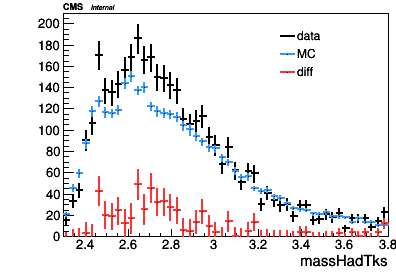

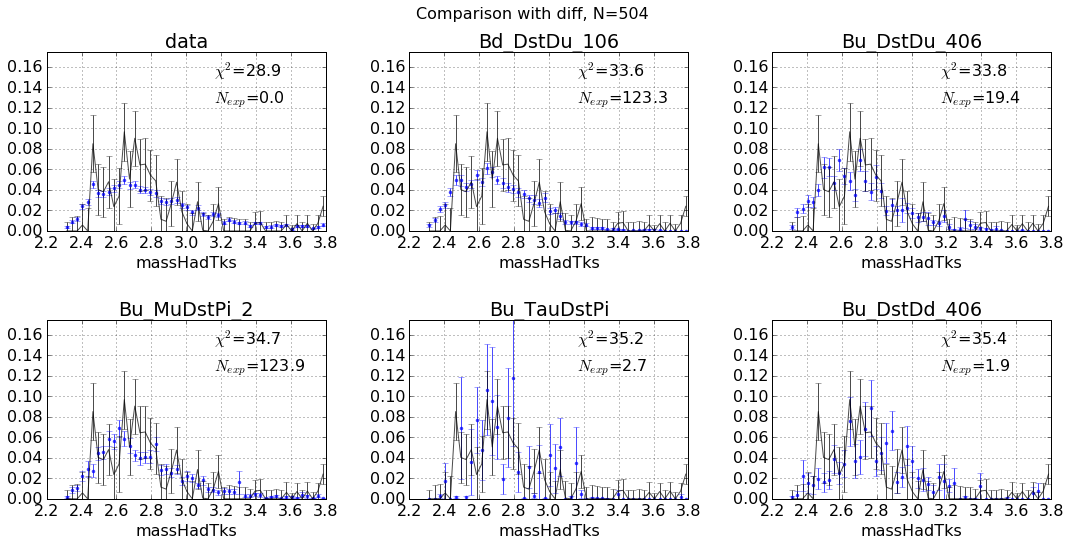

In [9]:
data['mHad'] = exploreDifference('massHadTks', [50, 2.3, 3.8])

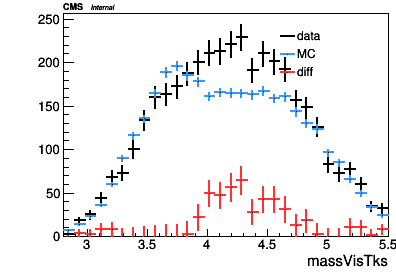

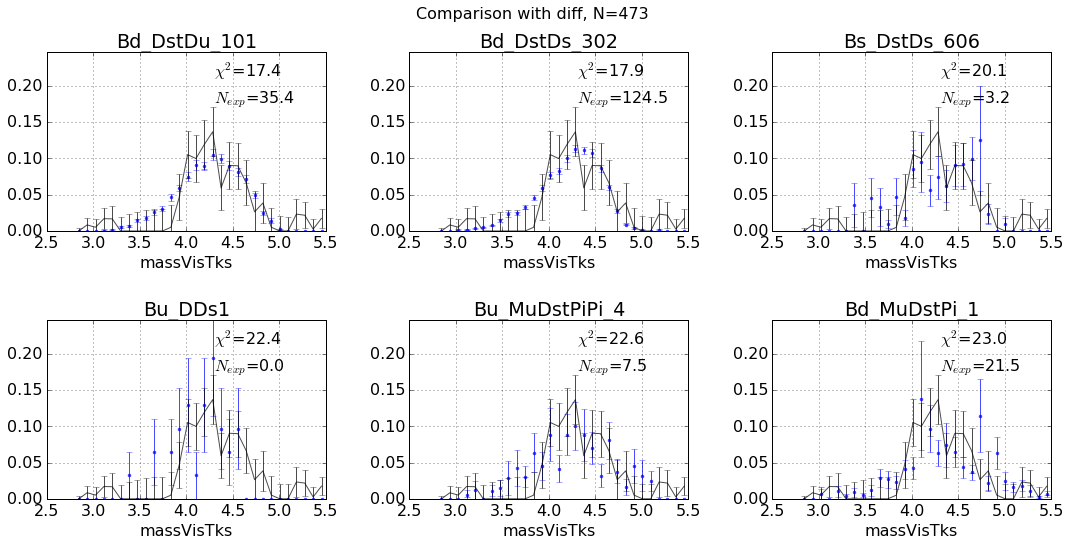

In [10]:
data['mVis'] = exploreDifference('massVisTks', [30, 2.8, 5.5])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


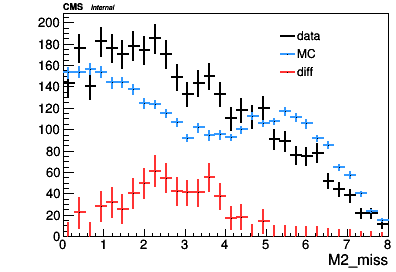

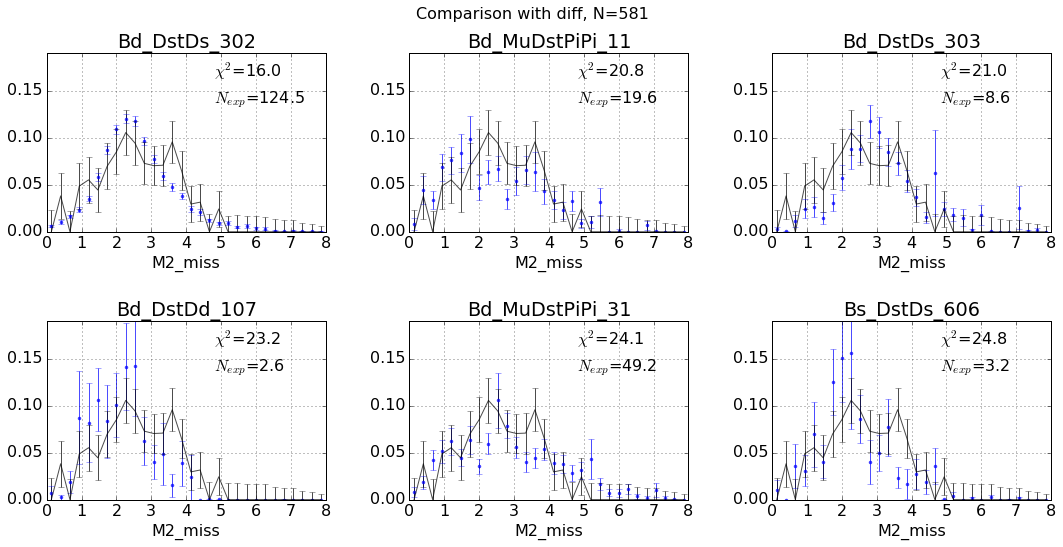

In [11]:
data['M2miss'] = exploreDifference('M2_miss', [30, 0, 8])